In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *
import scipy.stats as st
import matplotlib
import pickle
import scipy
from scipy.optimize import curve_fit

Using TensorFlow backend.


Initialized TensorFlow


In [2]:
def get_exp(epochs = 15, N = [200, 50], reg_coeff = 0.0005, reg_type = 'continuous', do_print = 'plot'):
    """ Train and return the result """
    def get_p_arr(p):
        """ p array with failure on the first layer """
        return [0, p]  + [0] * len(N)

    # Lips. coeff
    KLips = 1.

    # activation function
    activation = 'sigmoid'

    # training the network
    exp = MNISTExperiment(N = N, p_inference = get_p_arr(0), p_train = get_p_arr(0),
                          KLips = KLips, epochs = epochs,
                          activation = activation, reg_type = reg_type,
                          reg_coeff = reg_coeff, do_print = do_print,
                          name = 'experiment_weights', seed = None, batch_size = 1000)
    
    # returning the weights in the middle
    return exp

In [3]:
# dimensions to try
# can train up to 3500
Ns = [int(t) for t in np.linspace(50, 3500, 15)]

# how much repetitions for each experiment are needed?
repetitions = 3

print('Sizes', Ns)
print('Repetitions', repetitions)
print('Total runs', len(Ns) * repetitions)

Sizes [50, 296, 542, 789, 1035, 1282, 1528, 1775, 2021, 2267, 2514, 2760, 3007, 3253, 3500]
Repetitions 3
Total runs 45


In [4]:
# parameters for each experiment
parameters = {'reg_coeff': 0, 'reg_type': None, 'do_print': 'plot', 'epochs': 15}

In [5]:
def parameters_for_N(N):
    """ Parameters for get_exp for a particular N """
    param1 = {x: y for x, y in parameters.items()}
    param1['N'] = [N, 100]
    return param1

In [6]:
def experiment_for_N(N):
    """ Experiment with N """
    return get_exp(**parameters_for_N(N))

In [7]:
def W_inf_norm(exp):
    """ Returns Inf-norms for weight matrices, to show continuous
    limit (there they must stay ~constant and not blow up/decay) """
    
    # list of matrices
    Ws = exp.W
    
    # norms for everything
    Wnorms = {i: np.linalg.norm(W.T, ord = 1) for i, W in enumerate(Ws)}
    
    Wnorms['prod'] = np.prod([x for x in Wnorms.values()])
    
    return Wnorms

In [8]:
def mean_dLdy(exp, irange = range(60000)):
    """ Mean derivative w.r.t. the input for the model """
    # obtain the loss
    loss = exp.model_correct.loss(exp.output_tensor, exp.model_correct.output)

    # obtain first layer output
    y1 = exp.model_correct.layers[0].output

    # input tensor
    inp = exp.model_correct.input

    # output tensor with answers
    out = exp.output_tensor

    # gradients w.r.t. first layer output
    dL_dy1 = tf.gradients(loss, y1)[0]

    # some input/output pairs
    x = exp.x_train[irange]
    y = exp.y_train[irange]

    # mean over everything, should decay as 1/n_l
    dL_dy1_abs_mean_B_mean_N = tf.reduce_mean(tf.reduce_mean(tf.abs(dL_dy1), axis = 0))

    sess = get_session()

    return sess.run(dL_dy1_abs_mean_B_mean_N, feed_dict = {inp: x, out: y})

  0%|          | 0/15 [00:00<?, ?it/s]

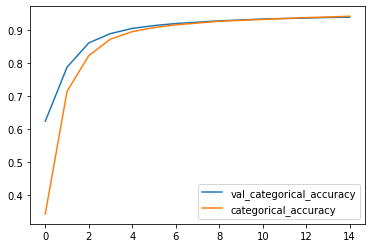

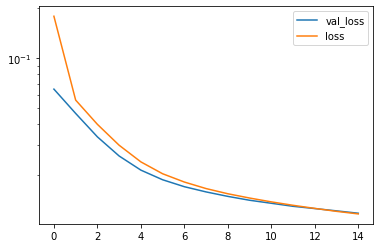

  7%|▋         | 1/15 [00:05<01:21,  5.84s/it]

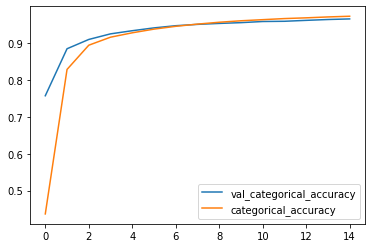

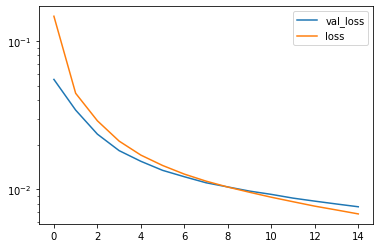

 13%|█▎        | 2/15 [00:11<01:15,  5.83s/it]

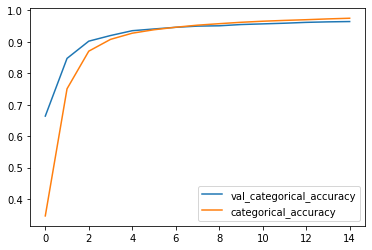

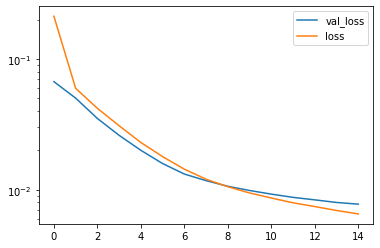

 20%|██        | 3/15 [00:17<01:11,  5.99s/it]

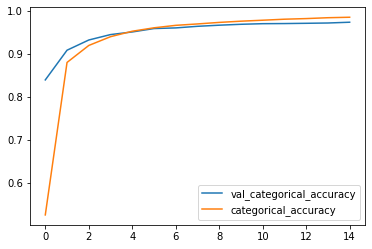

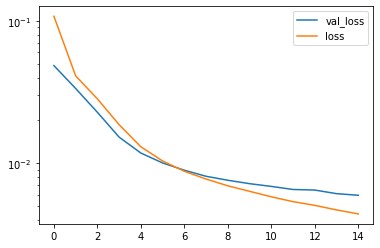

 27%|██▋       | 4/15 [00:25<01:09,  6.34s/it]

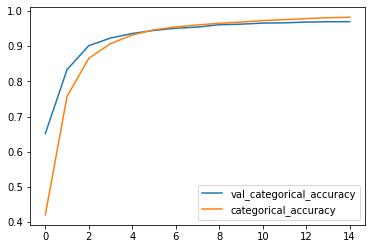

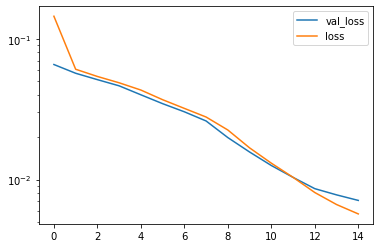

 33%|███▎      | 5/15 [00:32<01:06,  6.67s/it]

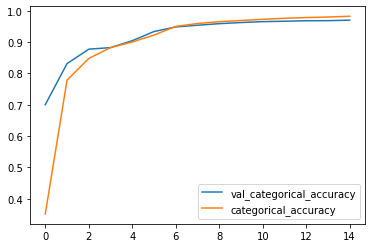

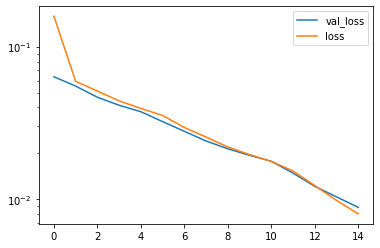

 40%|████      | 6/15 [00:40<01:04,  7.19s/it]

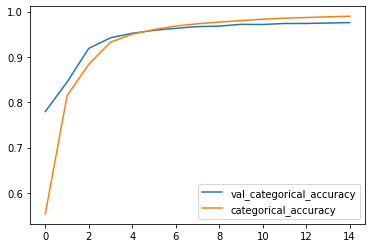

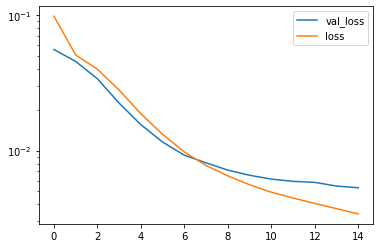

 47%|████▋     | 7/15 [00:49<01:00,  7.57s/it]

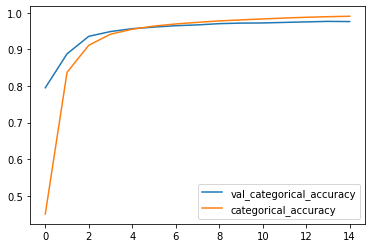

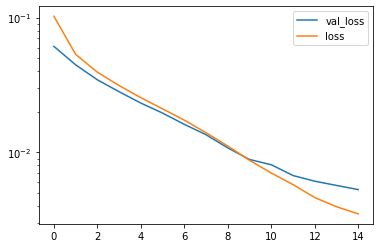

 53%|█████▎    | 8/15 [00:57<00:54,  7.79s/it]

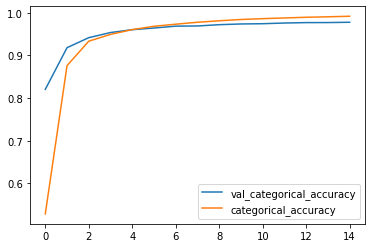

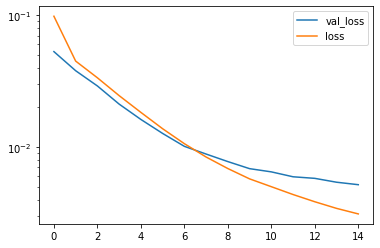

 60%|██████    | 9/15 [01:05<00:46,  7.81s/it]

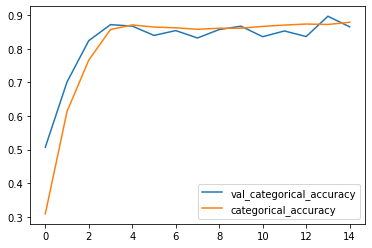

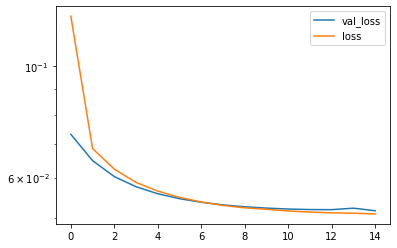

 67%|██████▋   | 10/15 [01:14<00:41,  8.26s/it]

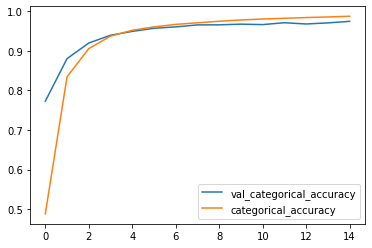

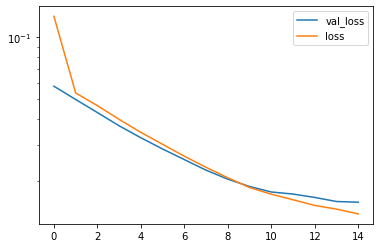

 73%|███████▎  | 11/15 [01:23<00:33,  8.46s/it]

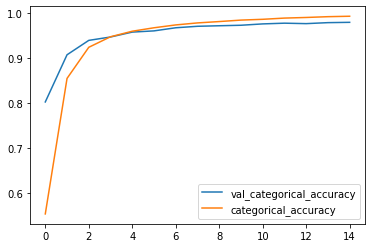

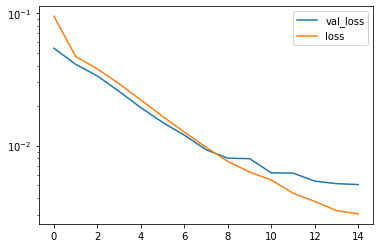

 80%|████████  | 12/15 [01:34<00:27,  9.11s/it]

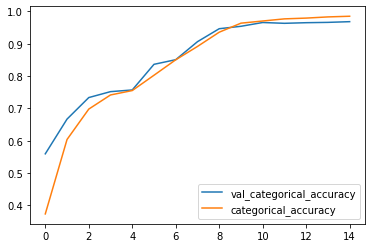

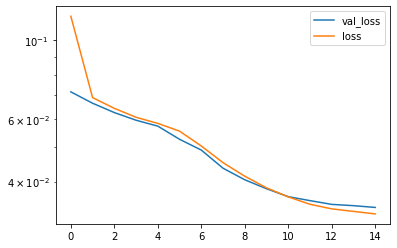

 87%|████████▋ | 13/15 [01:45<00:19,  9.76s/it]

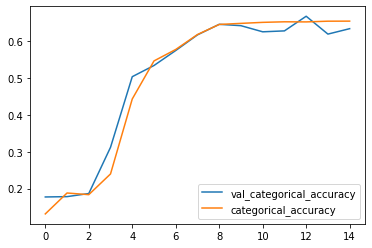

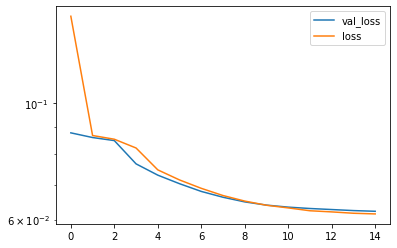

 93%|█████████▎| 14/15 [01:56<00:10, 10.20s/it]

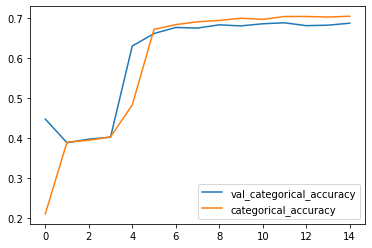

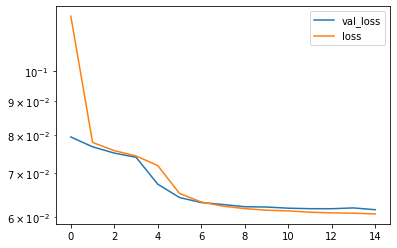

100%|██████████| 15/15 [02:08<00:00,  8.55s/it]


In [9]:
results = []
for N in tqdm(Ns):
    exp = experiment_for_N(N)
    results.append(W_inf_norm(exp))

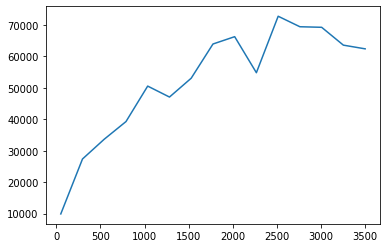

In [10]:
# first layer is blowing up...
# does it level out? yes
plt.plot(Ns, [x['prod'] for x in results])

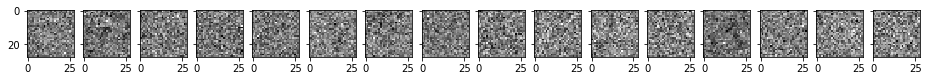

In [11]:
# showing neurons at first layer weight patterns
neurons_1 = [int(t) for t in np.linspace(0, exp.W[0].shape[0] - 1, 16)]

fig, axs = plt.subplots(1, len(neurons_1), figsize=(16, 3), sharex='row', sharey = 'row')

for i, n in enumerate(neurons_1):
    axs[i].imshow(exp.W[0][n,:].reshape(28, 28), cmap = 'gray')
plt.show()

### Does it level out because the accuracy is low?